# Equilibration (squeeze) procedure analysis 

The goal of this notebook is to analyze the crystal system configuration sampled during the squeeze (volume equilibration) step. We will focus on the proteins in the crystal and check the torsional angles as well as the distances of contacting residues at the interfaces.

In [1]:
import mdtraj
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mdtools.utils import unwrap_time_axis

In [19]:
traj = mdtraj.load('../Crystal_system_construction/iter04.h5')
unwrap_time_axis(traj, selection=traj.topology.select('not water'))

/n/home11/ziz531/miniconda3/envs/openmm/lib/python3.7/site-packages/mdtools-0.1.3-py3.7.egg/mdtools/utils.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if selection == 'all':


In [20]:
traj[::100].save('iter04.pdb')

In [5]:
print(f"We have {traj.n_chains} chains")

We have 13 chains


In [6]:
chain = traj.atom_slice(traj.topology.select('chainid==0'))

In [7]:
print(f"We have {chain.n_atoms} atoms and {chain.n_residues} residues in the first chain.")

We have 3621 atoms and 229 residues in the first chain.


In [8]:
_, phi = mdtraj.compute_phi(chain)
_, psi = mdtraj.compute_psi(chain)

print("The shape of phi and psi arrays are", phi.shape, psi.shape)

The shape of phi and psi arrays are (5001, 226) (5001, 226)


Why we are missing 2 phi and psi angles? It seems that this is due to mdtraj not recognizing the CRO residue. 

In [87]:
for i, res in enumerate(list(chain.topology.residues)[:-1]):
    residue = traj.atom_slice(traj.topology.select(f'chainid==0 and (resid=={i} or resid=={i+1})'))
    _, psi_ = mdtraj.compute_psi(residue)
    _, phi_ = mdtraj.compute_phi(residue)
    print(f'residue {i+1}, {res.name}, has # psi angle: {psi_.shape[1]}, # phi angle: {phi_.shape[1]}')

residue 1, MET, has # psi angle: 1, # phi angle: 1
residue 2, VAL, has # psi angle: 1, # phi angle: 1
residue 3, SER, has # psi angle: 1, # phi angle: 1
residue 4, LYS, has # psi angle: 1, # phi angle: 1
residue 5, GLY, has # psi angle: 1, # phi angle: 1
residue 6, GLU, has # psi angle: 1, # phi angle: 1
residue 7, GLU, has # psi angle: 1, # phi angle: 1
residue 8, LEU, has # psi angle: 1, # phi angle: 1
residue 9, PHE, has # psi angle: 1, # phi angle: 1
residue 10, THR, has # psi angle: 1, # phi angle: 1
residue 11, GLY, has # psi angle: 1, # phi angle: 1
residue 12, VAL, has # psi angle: 1, # phi angle: 1
residue 13, VAL, has # psi angle: 1, # phi angle: 1
residue 14, PRO, has # psi angle: 1, # phi angle: 1
residue 15, ILE, has # psi angle: 1, # phi angle: 1
residue 16, LEU, has # psi angle: 1, # phi angle: 1
residue 17, VAL, has # psi angle: 1, # phi angle: 1
residue 18, GLU, has # psi angle: 1, # phi angle: 1
residue 19, LEU, has # psi angle: 1, # phi angle: 1
residue 20, ASP, has 

Next, we will preprocess the dihedrals using the max gap shift method.

In [9]:
from scipy.ndimage import convolve1d
from typing import List
def find_max_cut(angles: np.ndarray) -> np.float32:
    hist_counts, bin_edge = np.histogram(angles, bins=np.linspace(-np.pi,np.pi,36))
    while sum(hist_counts == min(hist_counts)) > 1:
        hist_counts = convolve1d(hist_counts, [1,1,1], mode='wrap')
    min_bin_idx = np.argmin(hist_counts) # uniqueness ensured
    return (bin_edge[min_bin_idx] + bin_edge[min_bin_idx+1])/2

def apply_max_gap_shift(dataset: np.ndarray, inplace=False, indices: List[int]=None) -> np.ndarray: # dataset must be in row form
    if not inplace: dataset = np.copy(dataset)
    if indices is None: indices = range(dataset.shape[1])
    max_cuts = [find_max_cut(dataset[:, i]) for i in indices]
    for i, cut in enumerate(max_cuts):
        dataset[:, i] = (dataset[:, i] - cut) % (2*np.pi) - np.pi
    if not inplace: return (dataset, max_cuts)
    return max_cuts

In [10]:
_ = apply_max_gap_shift(phi, inplace=True)
_ = apply_max_gap_shift(psi, inplace=True)

In [11]:
dihedrals = np.concatenate((phi, psi), axis=1)
print("The shape of the combined array is,", dihedrals.shape)

The shape of the combined array is, (5001, 452)


In [12]:
pca = PCA()
dihedral_pcs = pca.fit_transform(dihedrals)
print("The shape of the dihedral principle components array is,", dihedral_pcs.shape)

The shape of the dihedral principle components array is, (5001, 452)


Text(0.5, 1.0, 'PCA projection of dihedral angles (chain 1)')

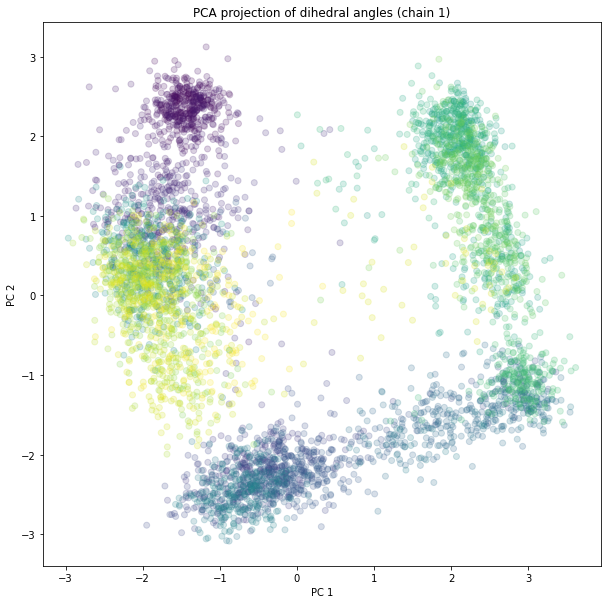

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(dihedral_pcs[:,0], dihedral_pcs[:,1], c=np.arange(dihedral_pcs.shape[0]), alpha=0.2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA projection of dihedral angles (chain 1)")

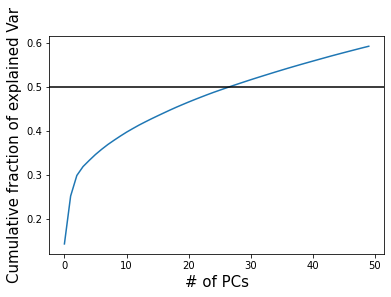

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[:50]))
plt.xlabel('# of PCs', fontsize=15)
plt.ylabel('Cumulative fraction of explained Var', fontsize=15)
plt.axhline(y=0.5, c='k')

We note there does seem to be a shift in the distribution of dihedral features (via PCA projection) over time. This makes sense because as described in the earlier notebook. We gradually taper off the constraints on heavy atoms until 2ns mark, which is at the 1000th frame. We will separately plot the two groups and compare.

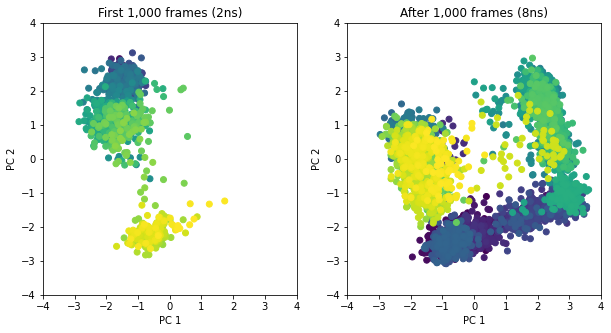

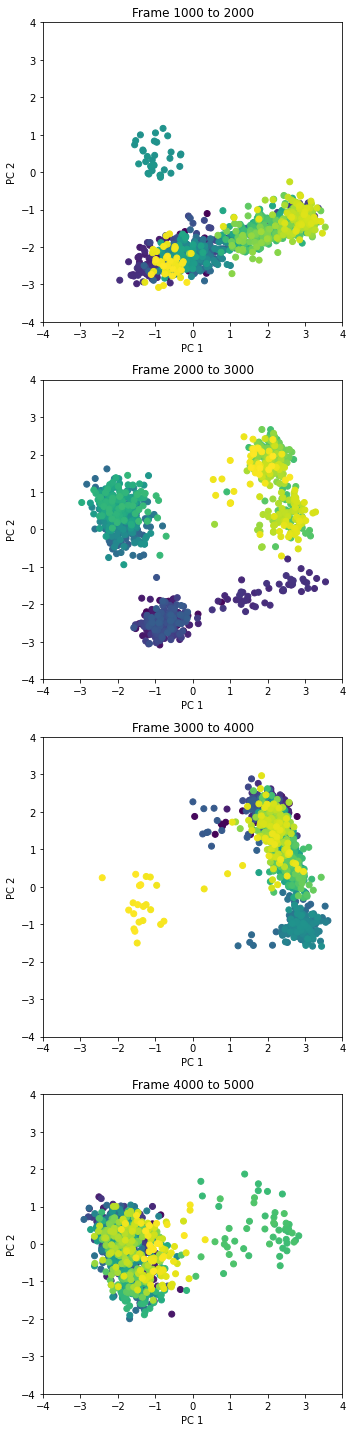

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))

t_threshold = 1000
ax[0].scatter(dihedral_pcs[:t_threshold,0], dihedral_pcs[:t_threshold,1], 
              c=np.arange(len(dihedral_pcs[:t_threshold,0])), alpha=1)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[0].set_title("First 1,000 frames (2ns)")
ax[0].set_xlim([-4, 4])
ax[0].set_ylim([-4, 4])
ax[1].scatter(dihedral_pcs[t_threshold:,0], dihedral_pcs[t_threshold:,1], 
              c=np.arange(len(dihedral_pcs[t_threshold:,0])), alpha=1)
ax[1].set_xlabel("PC 1")
ax[1].set_ylabel("PC 2")
ax[1].set_title("After 1,000 frames (8ns)")
ax[1].set_xlim([-4, 4])
ax[1].set_ylim([-4, 4])

dt = 1000
t_max = len(dihedrals)
t_begin_arr = np.arange(t_threshold, t_max, dt)[:-1]
fig, ax = plt.subplots(len(t_begin_arr), figsize=(5, len(t_begin_arr)*5))

for i, t_begin in enumerate(t_begin_arr):
    ax[i].scatter(dihedral_pcs[t_begin:t_begin+1000,0], dihedral_pcs[t_begin:t_begin+1000:,1], 
                  c=np.arange(1000), alpha=1)
    ax[i].set_xlabel("PC 1")
    ax[i].set_ylabel("PC 2")
    ax[i].set_title(f"Frame {t_begin} to {t_begin+1000}")
    ax[i].set_xlim([-4, 4])
    ax[i].set_ylim([-4, 4])
plt.tight_layout()

While we see that after tapering off the constraints, the distribution of dihedral features still doesn't appear stationary in time.

As a sanity check, let's first look at the distribution of some dihedrals in the last 100 frame of the trajectory.

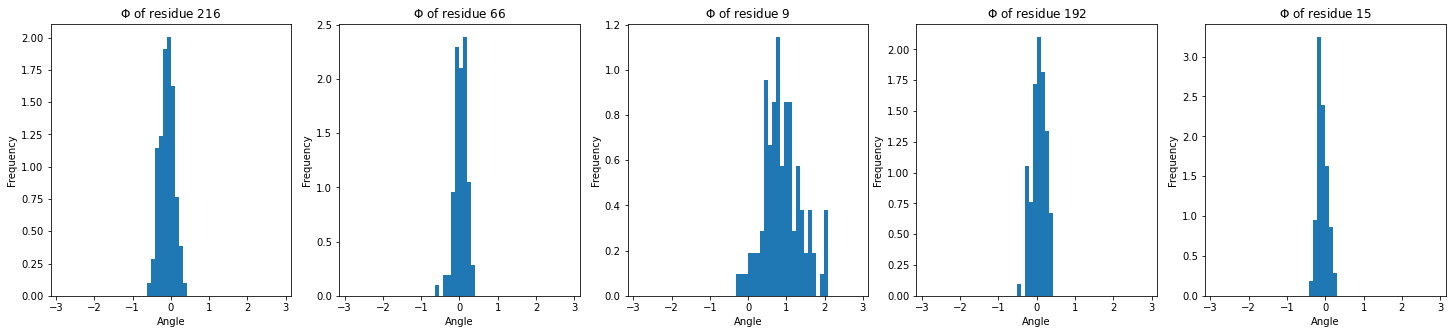

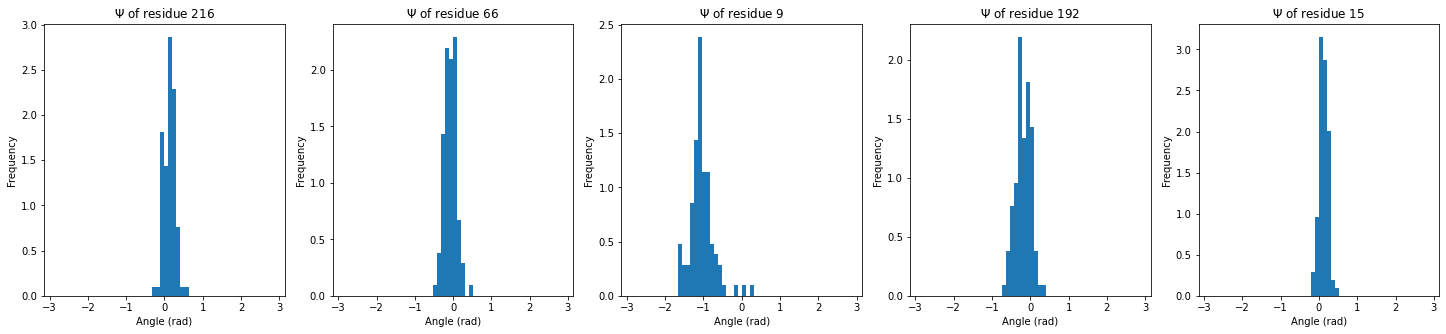

In [16]:
n = 5 # number of residues we want to look at
T = 100
np.random.seed(42)
res_ids = np.random.choice(np.arange(0, chain.n_residues), n, replace=False)

fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
for i in range(n):
    ax[i].hist(phi[-T:, res_ids[i]], density=True, range=(-np.pi, np.pi), bins=60)
    ax[i].set_xlim([-np.pi, np.pi])
    ax[i].set_xlabel("Angle")
    ax[i].set_ylabel("Frequency")
    ax[i].set_title(f"$\Phi$ of residue {res_ids[i]}")
    
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
for i in range(n):
    ax[i].hist(psi[-T:, res_ids[i]], density=True, range=(-np.pi, np.pi), bins=60)
    ax[i].set_xlim([-np.pi, np.pi])
    ax[i].set_xlabel("Angle (rad)")
    ax[i].set_ylabel("Frequency")
    ax[i].set_title(f"$\Psi$ of residue {res_ids[i]}")


We see that the width of the distributions are about 0.6-1 rad, or about 30-60 degrees.

We can also study the fluctuation of the dihedral angles at the beginning of the squeeze run.

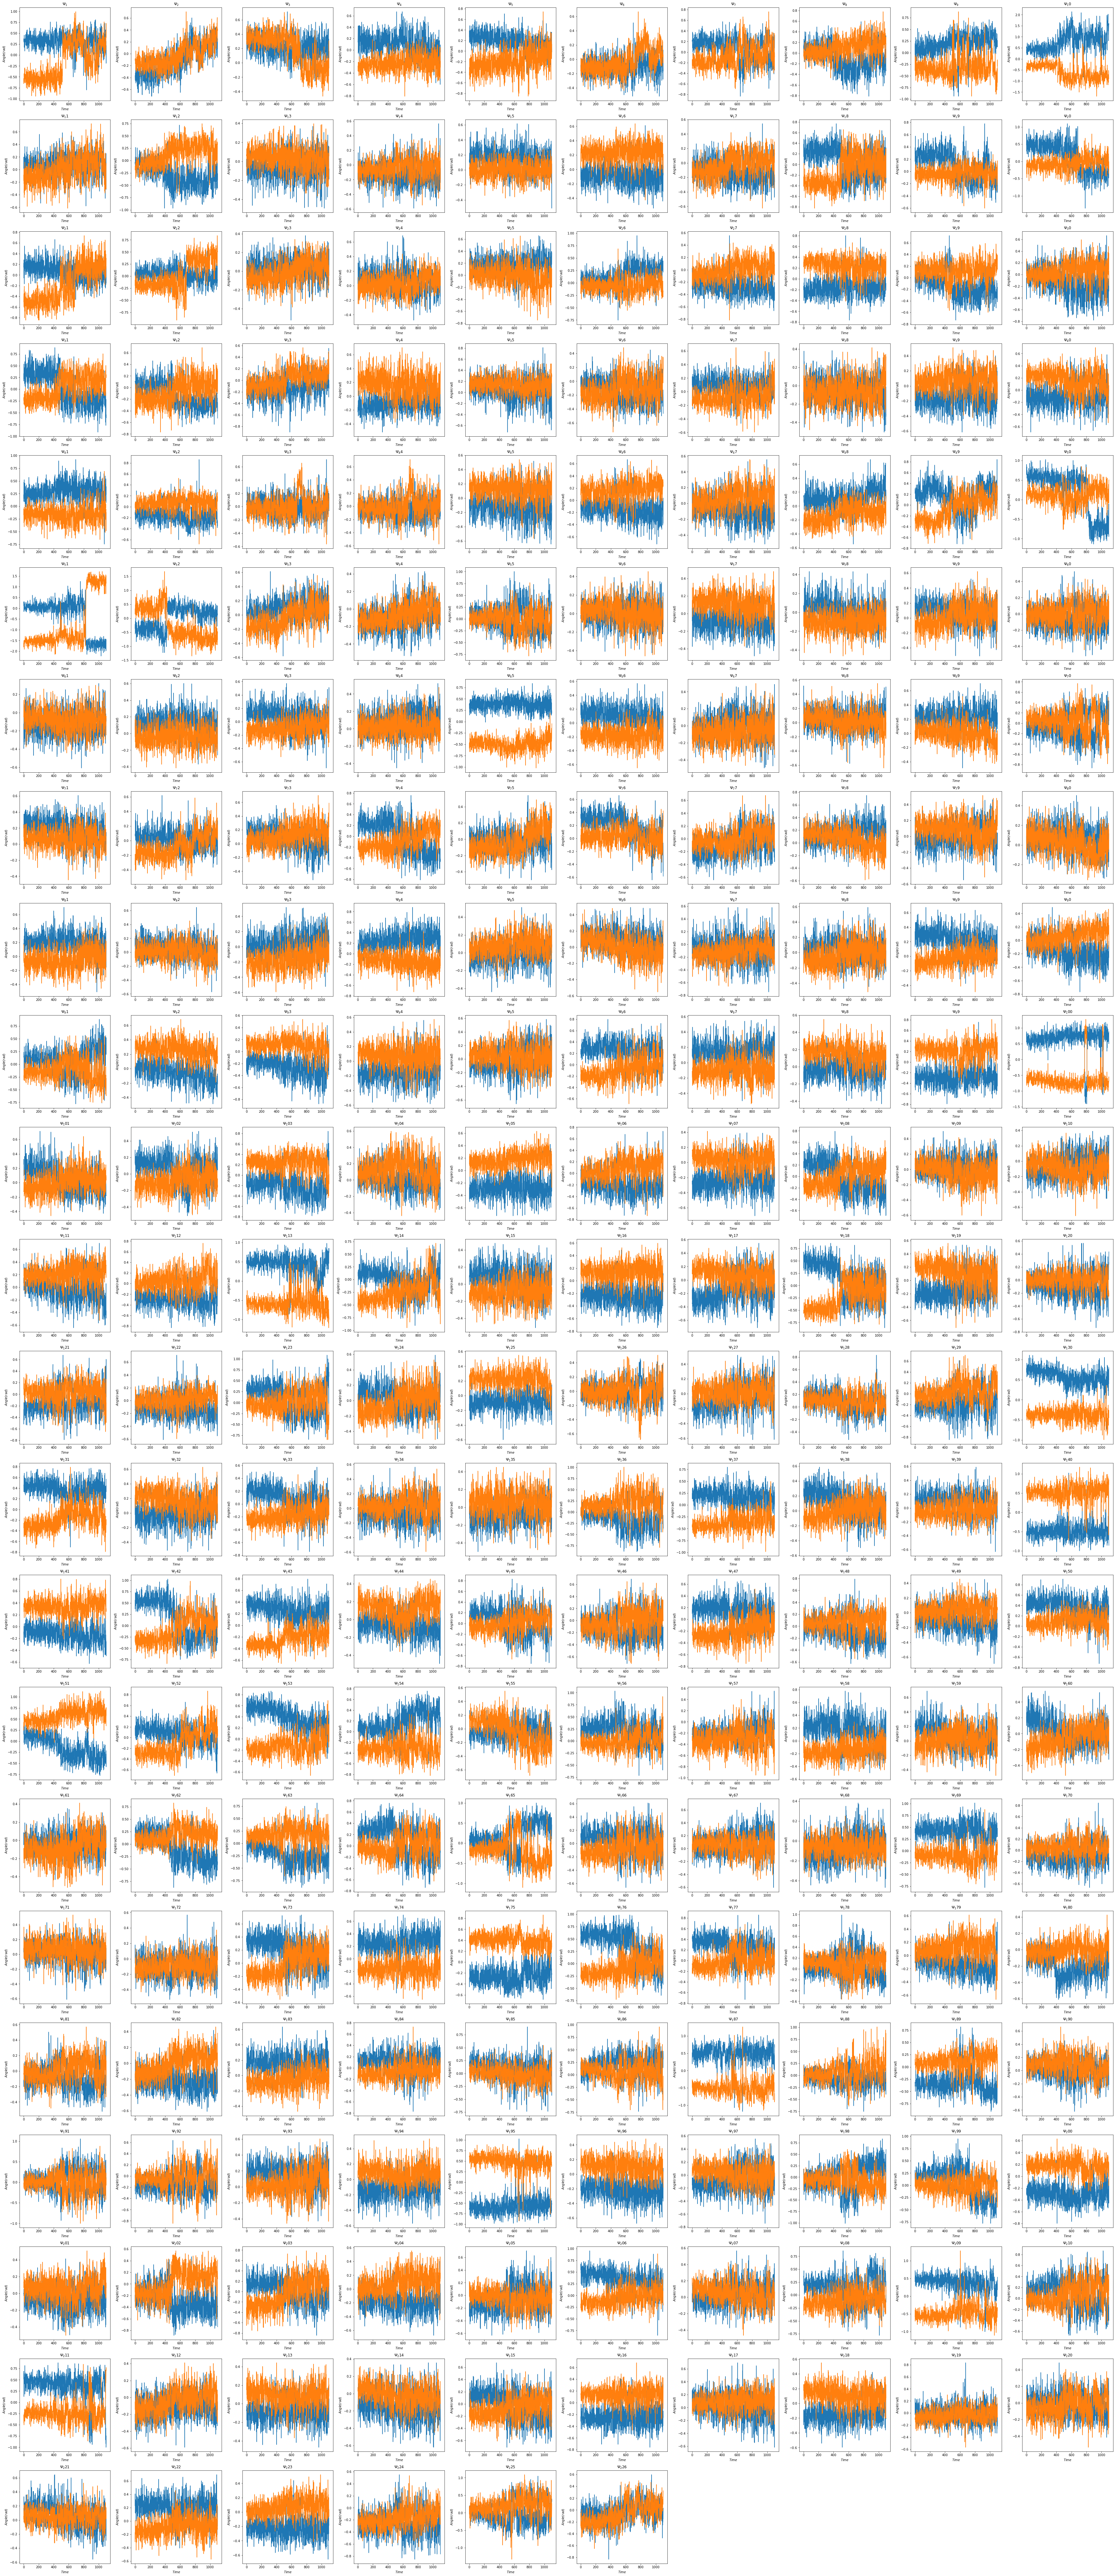

In [94]:
n = 5 # number of residues we want to look at
T = 1100
np.random.seed(42)
res_ids = np.random.choice(np.arange(0, chain.n_residues), n, replace=False)

nrows = chain.n_residues//10 * 2
plt.figure(figsize=(50, 5*nrows))

for i in range(phi.shape[1]):
    ax = plt.subplot(nrows, 10, i+1)
    ax.plot(phi[:T, i])
    ax.set_xlabel("$Time$", fontsize=10)
    ax.set_ylabel("$Angle (rad)$", fontsize=10)
    ax.set_title(f"$\Phi_\{{i+1}\}$")
    ax = plt.subplot(nrows, 10, i+1)
    ax.plot(psi[:T, i])
    ax.set_xlabel("$Time$", fontsize=10)
    ax.set_ylabel("$Angle (rad)$", fontsize=10)
    ax.set_title(f"$\Psi_\{{i+1}\}$")
plt.tight_layout()